# 04. Hyper‑parameter Optimization (Optuna) 
Notebook dedicado exclusivamente a la búsqueda de hiperparámetros para los
modelos multilabel de *Steel Plate Defect Prediction*.
 
* Dependencias clave: `optuna`, `lightgbm`, `scikit‑learn`, `hpo.py` (este repo).
* Resultado: archivos `best_params_<modelo>.json` + base de datos `.db` con el
  estudio completo dentro de `models/hpo/`.


In [3]:
# Imports y paths básicos
from pathlib import Path
import sys, os
import json
import optuna
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)
print(root)

C:\Users\ignag\OneDrive\Documentos\tfg‑steel‑plate‑defects


In [7]:
from src import ROOT_DIR
from src.models.hpo import run_hpo, HPO_DIR

In [9]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

## 1. Configuración 
Modifica el diccionario `CFG` para lanzar distintas búsquedas (modelo, nº de
ensayos, folds, etc.).

In [11]:
CFG = {
    "model_name": "lgbm",   # opciones: 'lgbm', 'rf', 'logreg'
    "n_trials": 10,      # aumenta cuando tengas más tiempo/recursos
    "n_splits": 5,
}
print("Configuración:", CFG)

Configuración: {'model_name': 'lgbm', 'n_trials': 10, 'n_splits': 5}


## 2. Lanzar la optimización
Esto puede tardar de minutos a horas según el número de *trials* y el modelo.
Los resultados quedan persistidos automáticamente, por lo que la celda es
**reentrante**: si la vuelves a ejecutar, sólo añadirá nuevos *trials*.

In [13]:
run_hpo(**CFG)

Best trial: 27. Best value: 0.882925: 100%|███████████████████████████████████████████| 10/10 [26:48<00:00, 160.85s/it]


Mejores hiperparámetros:
{
  "lgb_n_estimators": 556,
  "lgb_learning_rate": 0.03968658863235112,
  "lgb_num_leaves": 127,
  "lgb_max_depth": 3,
  "lgb_min_child_weight": 0.8399310030790329,
  "lgb_subsample": 0.9582935175639912,
  "lgb_colsample_bytree": 0.8065053278304177,
  "lgb_reg_alpha": 0.022862364661665684,
  "lgb_reg_lambda": 9.477174410400096e-06
}

AUC media validación: 0.88293
Guardado en: reports\hpo\best_params_lgbm.json


## 3. Cargar el estudio y analizar resultados
Aquí exploramos rápidamente el *study* generado para ver evolución de la
métrica y los diez mejores *trials*.

In [19]:
study_name = f"hpo_{CFG['model_name']}"
study = optuna.load_study(
    study_name=study_name,
    storage=f"sqlite:///{HPO_DIR}/{study_name}.db",
)

# Tabla completa (opcional)
trials_df = study.trials_dataframe()
trials_df.head()

,number,value,datetime_start,datetime_complete,duration,params_lgb_colsample_bytree,params_lgb_learning_rate,params_lgb_max_depth,params_lgb_min_child_weight,params_lgb_n_estimators,params_lgb_num_leaves,params_lgb_reg_alpha,params_lgb_reg_lambda,params_lgb_subsample,state
0,0,NaN,2025-05-12 11:49:28.789847,2025-05-12 11:49:28.886967,0 days 00:00:00.097120,0.623233,0.226482,9,0.004208,749,195,NaN,NaN,0.662398,FAIL
1,1,0.818848,2025-05-12 11:53:47.904280,2025-05-12 11:54:01.481792,0 days 00:00:13.577512,0.623233,0.226482,9,0.004208,749,195,0.624576,2.570604e-03,0.662398,COMPLETE
2,2,0.879429,2025-05-12 11:54:01.517792,2025-05-12 11:56:04.931064,0 days 00:02:03.413272,0.673362,0.001125,13,0.007069,1150,249,0.000005,5.282115e-04,0.672730,COMPLETE
3,3,0.850365,2025-05-12 11:56:04.960215,2025-05-12 11:56:11.008000,0 days 00:00:06.047785,0.782428,0.005265,1,0.014743,818,168,0.116569,6.267063e-07,0.746545,COMPLETE
4,4,0.729165,2025-05-12 11:56:11.039000,2025-05-12 11:56:26.461310,0 days 00:00:15.422310,0.979554,0.029342,9,0.004809,917,41,4.905557,1.886150e-01,0.626021,COMPLETE


C:\Users\ignag\AppData\Local\Temp\ipykernel_6976\1485708643.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


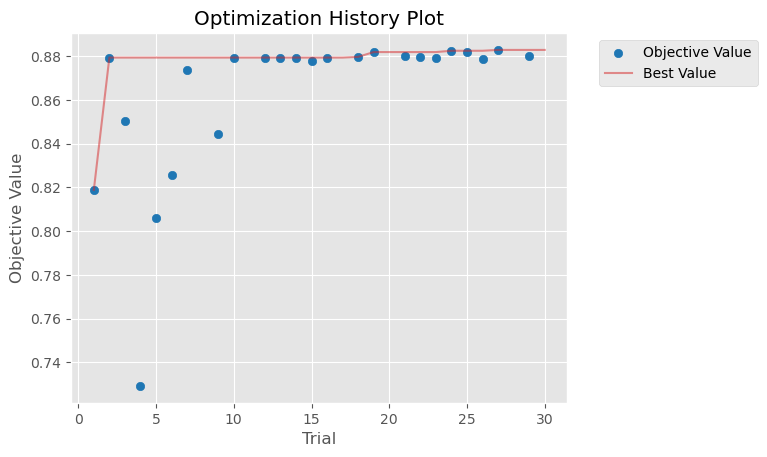

,value,params_lgb_colsample_bytree,params_lgb_learning_rate,params_lgb_max_depth,params_lgb_min_child_weight,params_lgb_n_estimators,params_lgb_num_leaves,params_lgb_reg_alpha,params_lgb_reg_lambda,params_lgb_subsample
27,0.882925,0.806505,0.039687,3,0.839931,556,127,0.022862,9.477174e-06,0.958294
24,0.882541,0.797053,0.011447,5,0.244335,1309,107,0.018235,5.978979e-06,0.836716
19,0.881943,0.649293,0.018784,4,0.344124,1257,107,0.003525,2.041469e-08,0.833291
25,0.881773,0.805343,0.010214,-1,0.877556,955,78,0.027134,5.241682e-06,0.844702
21,0.880033,0.746352,0.010506,-1,0.334455,1299,79,0.002737,4.940064e-06,0.830045
29,0.880009,0.890217,0.029886,6,0.156135,545,63,0.000524,2.155026e-05,0.951222
18,0.879750,0.663996,0.019211,5,0.336529,1287,106,0.002471,2.485742e-08,0.798417
22,0.879465,0.736665,0.011205,-1,0.306200,1341,80,0.003662,1.157626e-07,0.854740
2,0.879429,0.673362,0.001125,13,0.007069,1150,249,0.000005,5.282115e-04,0.672730
10,0.879429,0.673362,0.001125,13,0.007069,1150,249,0.000005,5.282115e-04,0.672730


In [21]:
# Plot de convergencia
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

# Diez mejores *trials*
cols = [c for c in trials_df.columns if c.startswith("params_") or c == "value"]
trials_df.sort_values("value", ascending=False).head(10)[cols]


## 4. Guardar/actualizar los mejores hiperparámetros


In [28]:
best_params_path = HPO_DIR / f"best_params_{CFG['model_name']}.json"
with open(best_params_path) as fh:
    best_params = json.load(fh)

print("Best params loaded:")
print(json.dumps(best_params, indent=2))

Best params loaded:
{
  "lgb_n_estimators": 556,
  "lgb_learning_rate": 0.03968658863235112,
  "lgb_num_leaves": 127,
  "lgb_max_depth": 3,
  "lgb_min_child_weight": 0.8399310030790329,
  "lgb_subsample": 0.9582935175639912,
  "lgb_colsample_bytree": 0.8065053278304177,
  "lgb_reg_alpha": 0.022862364661665684,
  "lgb_reg_lambda": 9.477174410400096e-06
}
